In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import datetime
import pickle

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Preprocessing

In [15]:
df = pd.read_excel('MicroRV_CW.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)

In [16]:
df

,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,BPSWSJ Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,0.19560,0.38050,0.38050,0.43390,0.61670,0.67380,0.74200,0.79440,0.84270,0.89160,...,1.18400,1.17000,1.15820,1.1314,1.11480,1.06650,1.02200,0.98120,0.89275,0.80450
2022-01-28,0.22930,0.38450,0.38450,0.43750,0.63216,0.69100,0.75890,0.81300,0.86277,0.91184,...,1.20635,1.19205,1.18135,1.1593,1.13870,1.09380,1.05250,1.01580,0.92410,0.83600
2022-01-31,0.33260,0.41175,0.41175,0.47100,0.66400,0.72300,0.79670,0.85310,0.90340,0.95515,...,1.25550,1.23790,1.22800,1.2130,1.18600,1.14400,1.10225,1.06700,0.98105,0.89615
2022-02-01,0.36900,0.42165,0.42165,0.47700,0.66610,0.72550,0.79400,0.85360,0.89930,0.94730,...,1.24800,1.23400,1.22400,1.2038,1.17790,1.13300,1.09200,1.05600,0.96620,0.88300
2022-02-02,0.40855,0.43415,0.43415,0.49000,0.67320,0.72580,0.79080,0.84631,0.89184,0.93803,...,1.22300,1.20800,1.19700,1.1750,1.14700,1.09600,1.05100,1.01100,0.92025,0.83355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,4.70180,4.70390,4.71000,4.70410,4.62260,4.59625,4.56487,4.53630,4.51151,4.48554,...,3.97335,3.97900,3.99100,4.0265,4.07392,4.10692,4.09602,4.05797,3.98100,3.86650
2024-11-20,4.70200,4.70390,4.71000,4.70400,4.61850,4.58900,4.55400,4.52600,4.49900,4.47290,...,3.94650,3.95450,3.96800,4.0060,4.05550,4.09050,4.08150,4.04400,3.96646,3.85300
2024-11-21,4.70200,4.70400,4.71000,4.69700,4.59500,4.56280,4.52550,4.49250,4.46300,4.43410,...,3.89800,3.90600,3.91850,3.9560,4.00500,4.03900,4.03096,3.99400,3.94695,3.83185


The columns are Bloomberg tickers for swap rates, quoted in basis points (bps)

`BPSWS` stand for Bloomberg Par Swap.

`BPSWS1 Curncy` 1-year par swap rate in bps

In [17]:
df.columns

Index(['BPSWS1Z Curncy', 'BPSWS2Z Curncy', 'BPSWSA Curncy', 'BPSWSB Curncy',
       'BPSWSE Curncy', 'BPSWSF Curncy', 'BPSWSG Curncy', 'BPSWSH Curncy',
       'BPSWSI Curncy', 'BPSWSJ Curncy', 'BPSWSK Curncy', 'BPSWS1 Curncy',
       'BPSWS1F Curncy', 'BPSWS2 Curncy', 'BPSWS3 Curncy', 'BPSWS4 Curncy',
       'BPSWS5 Curncy', 'BPSWS6 Curncy', 'BPSWS7 Curncy', 'BPSWS8 Curncy',
       'BPSWS9 Curncy', 'BPSWS10 Curncy', 'BPSWS12 Curncy', 'BPSWS15 Curncy',
       'BPSWS20 Curncy', 'BPSWS25 Curncy', 'BPSWS30 Curncy', 'BPSWS40 Curncy',
       'BPSWS50 Curncy'],
      dtype='object')

In [18]:
columns = ['1W','2W']
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')
for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')

print(columns)

for old_name, new_name in zip(df.columns, columns):
    df.rename(columns={old_name: new_name}, inplace=True)

print(df.columns)

['1W', '2W', '1M', '2M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']
Index(['1W', '2W', '1M', '2M', '5M', '6M', '7M', '8M', '9M', '10M', '11M',
       '1Y', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y',
       '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y'],
      dtype='object')


Convert units to year

In [5]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])

date = df.index[0]
# y is quote on first date
y = df.loc[date, selected_tenors].values

In [22]:
tenors_dict.keys(), tenors_dict['1W']

(dict_keys(['1W', '2W', '1M', '2M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']),
 np.float64(0.019230769230769232))

In [19]:
x.shape, y.shape

((29,), (29,))

# Apply $C^2$ cubic spline interpolation on quotes from the df to build curve

Text(0, 0.5, 'Rate (%)')

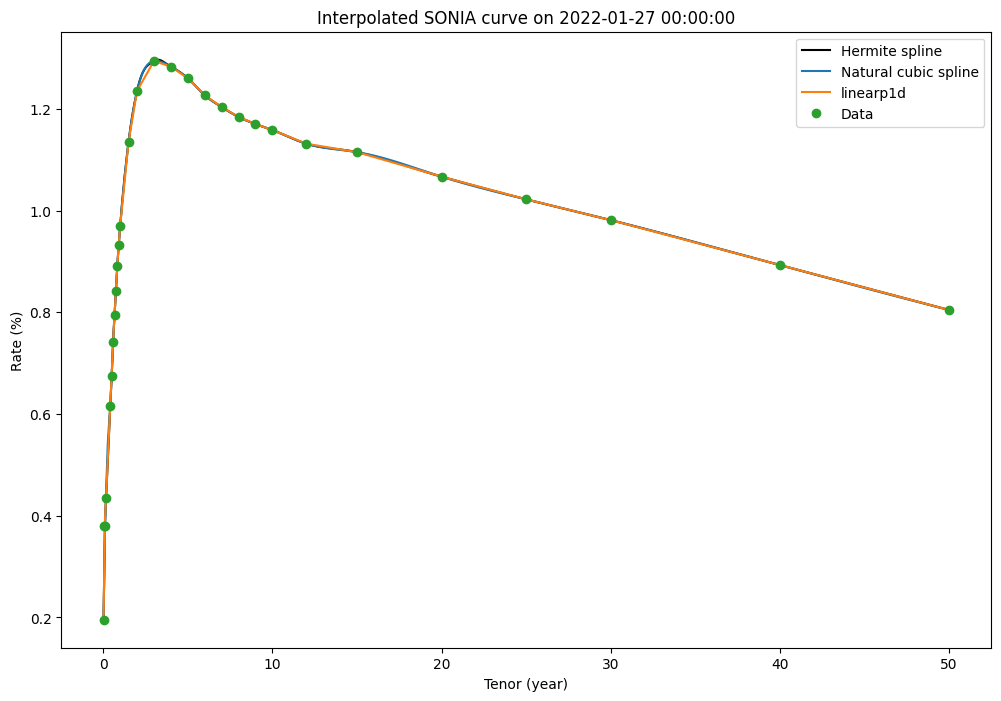

In [ ]:
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline',color='black')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date}')
plt.ylabel('Rate (%)')

# Plot curve

`curve`: an instance of IborSingleCurve, which has methods like .zero_rate(), .fwd(), .fwd_rate()

`start_date`: the valuation or anchor date for the curve

`tmax`: max horizon in years (e.g. 30)

The function plots:

Zero-coupon rates (`curve.zero_rate(...)`)

Instantaneous/ON forward rates (`curve.fwd(...)`)

Term forward rates over list of tenors in `instr_mat_dates_or_tenor`

In [9]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [10]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
      swaps.append(swap)

Text(0.5, 1.0, 'Interpolated SONIA curve on 27-01-2022')

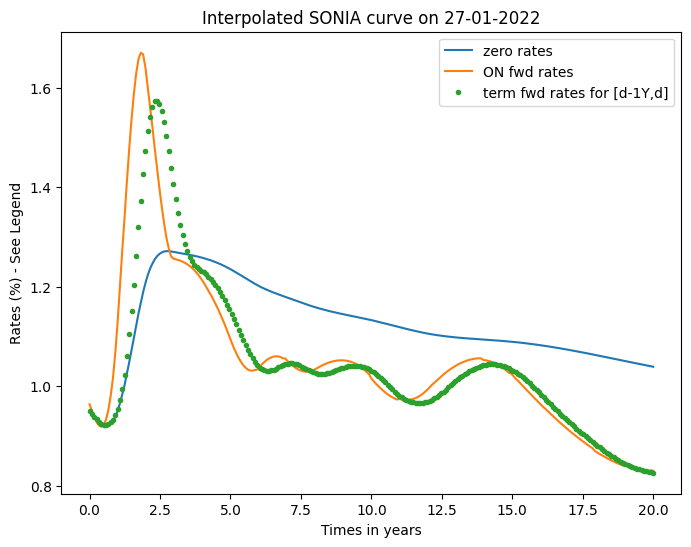

In [11]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}')

## Build curve for every date and store

Build from 2022-01-27 to 2024-11-25

In [12]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
    swaps = []
    day, month, year = date.day, date.month, date.year
    valuation_date = Date(day, month, year) # convet to Date object
    spot_days = 0 # T+0
    settlement_date = valuation_date.add_weekdays(spot_days)
    for tenor in df.columns: # loop through each tenor in the dataset
        if tenor[-1]=='Y':
            rate = df.loc[date, tenor]/100
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES)
    for year in year_columns:
        df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date,maturity_dt=valuation_date.add_years(year))
    curves[date] = curve # add this curve to the dictionary

Creating curves: 100%|██████████| 716/716 [04:30<00:00,  2.65it/s]


In [31]:
# curves contains the Ibor curve object for each date
date0 = next(iter(curves))
print(date0, type(curves[date0]))

# swap rate for each target year is stored in df_yield
df_yield.head(5)

2022-01-27 00:00:00 <class 'financepy.products.rates.ibor_single_curve.IborSingleCurve'>


,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50
Date,,,,,,,,,,,,,,,,,
2022-01-27,0.009690999984746235,0.012348848808019185,0.012951644106684965,0.012837215003426182,0.012607391349294814,0.012272622935394094,0.012044025134759094,0.011847909741687018,0.011707111581380863,0.01158837052420333,0.011321699436091712,0.011156052415306055,0.010672260557958297,0.010226669628276785,0.009818259189343813,0.008933584533534149,0.00805029720680981
2022-01-28,0.00995469989685892,0.012673402106503721,0.013241897739924858,0.013098889448265658,0.012833012546837023,0.012541746465387636,0.012269861684472383,0.012071703423928363,0.011927745603129607,0.011819998370643289,0.011600852043838736,0.01139522324051245,0.010945445847782866,0.010531911648727755,0.010164515825631298,0.009247328799667309,0.008365505500635102
2022-01-31,0.010390000417832421,0.01333899982284721,0.013941024172779084,0.01367429047003905,0.013312086710107612,0.01299595434001498,0.012729826456187063,0.01256353597356063,0.01238652468217701,0.01228657760642755,0.012138251392040871,0.011868445922956761,0.011447786224551622,0.011029737667757557,0.010676843863317572,0.009817183215179007,0.008967388911204622
2022-02-01,0.010312000289564383,0.013217999599979479,0.013871845082326322,0.013640504809198258,0.013300266308281896,0.012965939519130672,0.012695800374190165,0.012488485098673433,0.012347317981848677,0.012246641515783896,0.012046187678461894,0.011787443225243615,0.011337635688209578,0.01092717078964961,0.010566772385726637,0.009668582043468613,0.00883581547655299
2022-02-02,0.010182000696661503,0.013009999878816302,0.013611963177894372,0.013409101161458093,0.013087152549987735,0.012745841192638855,0.012459623035426953,0.012238078653737092,0.012087265882420586,0.011976584846861165,0.011757994032312008,0.011478282980903545,0.010967429481373477,0.010516834850903805,0.010116482185133904,0.009208771168596641,0.008340989034357607


In [25]:
import pickle

# Save curves dictionary
with open('curves.pkl', 'wb') as f:
    pickle.dump(curves, f)

# Save df_yield DataFrame
df_yield.to_pickle('df_yield.pkl')

### butterfly

In [26]:
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)  
df_yield = pd.read_pickle('df_yield.pkl')

## Compute fly spread and z-score using rolling window

Note given three rates, $ r_a < r_b < r_c$, 
the spread is defined as $ z = 2 r_b - r_a - r_c $

$z=0$ if $r_b$ is a linear interpolation

`fly_legs` is list of tuples like (1, 5, 10)

In [32]:
# z = 2 * rb - ra - rc
def compute_fly_from_curves(curves, fly_legs, window=60, rate_type='zero'):

    fly_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    zscore_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    dates = list(curves.keys())
    dates.sort()

    for idx in range(window, len(dates)):
        current_date = dates[idx]
        current_curve = curves[current_date]

        past_fly_dict = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}

        # fly spread in past window days
        for hist_date in dates[idx - window: idx]:
            hist_curve = curves[hist_date]
            for (a, b, c) in fly_legs:
                d_a = Date(hist_date.day, hist_date.month, hist_date.year).add_years(a)
                d_b = Date(hist_date.day, hist_date.month, hist_date.year).add_years(b)
                d_c = Date(hist_date.day, hist_date.month, hist_date.year).add_years(c)

                if rate_type == 'zero':
                    try:
                        ra = hist_curve.zero_rate(d_a)
                        rb = hist_curve.zero_rate(d_b)
                        rc = hist_curve.zero_rate(d_c)
                    except:
                        continue
                elif rate_type == 'forward':
                    try:
                        ra = hist_curve.fwd(d_a)
                        rb = hist_curve.fwd(d_b)
                        rc = hist_curve.fwd(d_c)
                    except:
                        continue
                else:
                    raise ValueError("rate_type must be 'zero' or 'forward'")

                fly_hist = 2 * rb - ra - rc
                past_fly_dict[f"{a}-{b}-{c}"].append(fly_hist)

        # fly spread on current date
        for (a, b, c) in fly_legs:
            d_a = Date(current_date.day, current_date.month, current_date.year).add_years(a)
            d_b = Date(current_date.day, current_date.month, current_date.year).add_years(b)
            d_c = Date(current_date.day, current_date.month, current_date.year).add_years(c)

            try:
                if rate_type == 'zero':
                    ra = current_curve.zero_rate(d_a)
                    rb = current_curve.zero_rate(d_b)
                    rc = current_curve.zero_rate(d_c)
                else:
                    ra = current_curve.fwd(d_a)
                    rb = current_curve.fwd(d_b)
                    rc = current_curve.fwd(d_c)

                fly_today = 2 * rb - ra - rc
                fly_data[f"{a}-{b}-{c}"].append(fly_today)

                hist_vals = past_fly_dict[f"{a}-{b}-{c}"]
                if len(hist_vals) >= 5:
                    mu = np.mean(hist_vals)
                    sigma = np.std(hist_vals)
                    z = (fly_today - mu) / sigma if sigma > 1e-6 else 0
                else:
                    z = np.nan
                zscore_data[f"{a}-{b}-{c}"].append(z)
            except:
                fly_data[f"{a}-{b}-{c}"].append(np.nan)
                zscore_data[f"{a}-{b}-{c}"].append(np.nan)

    fly_df = pd.DataFrame(fly_data, index=dates[window:])
    zscore_df = pd.DataFrame(zscore_data, index=dates[window:])
    return fly_df, zscore_df

In [33]:
fly_legs = [(2, 5, 10), (5, 10, 30), (3, 5, 7)]
kmonths = 60 # days, 3 months of trading days
fly_df_forward, z_df_forward = compute_fly_from_curves(curves, fly_legs, window=kmonths, rate_type='forward') 

In [36]:
fly_df_forward.head(5) # spread for each 

,2-5-10,5-10-30,3-5-7
2022-04-22,-0.015132,0.008405,-0.001185
2022-04-25,-0.012231,0.005903,0.001001
2022-04-26,-0.009827,0.004314,0.000075
2022-04-27,-0.006429,0.000866,0.000522
2022-04-28,-0.006199,0.002972,-0.000373


In [35]:
z_df_forward.head(5) # zscore for each fly spread

,2-5-10,5-10-30,3-5-7
2022-04-22,-5.372883,4.689686,-0.364990
2022-04-25,-2.634850,2.313313,1.992931
2022-04-26,-0.996120,1.182638,0.933699
2022-04-27,1.190154,-0.989463,1.370140
2022-04-28,1.351234,0.344556,0.399984


In [37]:
def select_best_trades(zscore_df,N=10):
    z_flat = zscore_df.stack().dropna()  # convert into series
    print('z flat shape:', z_flat.shape)
    return z_flat[z_flat.abs().sort_values(ascending=False).head(N).index]

best_10_trades = select_best_trades(z_df_forward,10)
best_10_trades

z flat shape: (1968,)


2024-07-30  3-5-7      6.710851
2024-09-06  3-5-7      6.249908
2022-09-27  5-10-30   -6.113262
2022-06-22  5-10-30    6.087881
2022-09-28  3-5-7     -5.918000
2022-04-22  2-5-10    -5.372883
2024-10-03  3-5-7     -5.243600
2022-09-29  5-10-30    5.107139
2022-09-27  2-5-10     5.104728
2022-06-22  2-5-10    -4.966668
dtype: float64

## Trading strategy

Fly Trade: $ 2 r_b - r_a - r_c$ (long belly rates, short the wings rates)

e.g. a 9y10y11y fly is being long (i.e. receive fixed, negative DV01) for the 9y1y forward swap, and being short (pay fixed, positive DV01) for the 10y1y forward swap.

Note 9y1y forward rate: 

$$
R(T_1, T_2) = -\frac{\log P(0, T_1) - \log P(0, T_2)}{T_2 - T_1} 
$$

$$
= -\frac{R(T_2) T_2 - R(T_1) T_1}{T_2 - T_1}
$$

so

$$
R(9, 10) = -\frac{10 \cdot R(10Y) - 9 \cdot R(9Y) }{10-9} 

= 10 R(10) - 9 R(9)
$$

Long 9Y1Y swap means receiving fixed $R(9, 10)$ and paying float, so we have DV01 < 0, as we want floating rate to be low

Long 9Y1Y and short 10Y1Y means $ 10 R(10) - 9 R(9) + 10 R(10) - 11 R(11) $

In our case where we have $r_a, r_b, r_c$, if we long $N_1$ of $R_{a,b}$ swap and short $N_2$ of $R_{b,c}$ swap, we have resulting rate 

$$
N_1 (b \cdot r_b - a \cdot r_a ) = N_2 (b \cdot r_b - c \cdot r_c)
$$ 

Notionals are scaled so the total DV01 is neutral, meaning it's hedged against small parallel shifts in the curve.

## Simulate PnL

`structure`: tuple (a,b,c), fly: 2b - a - c

#### {1. Notation}

\begin{array}{|c|c|c|}
\hline
\text{Code variable} & \text{Math symbol} & \text{Description} \\
\hline
\texttt{a, b, c} & a, b, c & \text{Maturities (in years) of the 3 swap legs} \\
\texttt{R\_x(t)} & R_x(t) & \text{Par swap rate of maturity } x \text{ at time } t \\
\texttt{DV01\_x} & \mathrm{DV01}_x & \text{DV01 of the } x\text{-year swap at time } t=0 \\
\texttt{N\_a = N\_c = N} & N & \text{Notional of the payer swaps} \\
\texttt{N\_b} & N_b & \text{Notional of the receiver swap} \\
\texttt{Pi(t)} & \Pi(t) & \text{Mark-to-market PnL at time } t \\
\hline
\end{array}

#### {2. DV01 estimation (function \texttt{swap\_dv01})}

The DV01 of an $x$-year swap is approximated by the sum of discounted payments:

$$
\mathrm{DV01}_x = \sum_{k=1}^{x} \tau \cdot P(0, t_k), \quad \tau = 1
$$

where $P(0, t_k)$ is the discount factor to the $k^\text{th}$ payment date.

#### {3. Construction of the fly and DV01 neutrality}

The strategy consists of:

- Pay fixed on an $a$-year swap $\Rightarrow$ sign $-1$
- Receive fixed on a $b$-year swap, with #### {double notional} $\Rightarrow$ sign $+2$
- Pay fixed on a $c$-year swap $\Rightarrow$ sign $-1$


To make the fly DV01-neutral, we set:

$$
- N \cdot \mathrm{DV01}_a + 2 N_b \cdot \mathrm{DV01}_b - N \cdot \mathrm{DV01}_c = 0
$$

Solving for $N_b$:

$$
N_b = \frac{N \cdot (\mathrm{DV01}_a + \mathrm{DV01}_c)}{2 \cdot \mathrm{DV01}_b}
$$

#### {4. PnL simulation logic}

At any future date $t$, for each leg $x \in \{a, b, c\}$:

$$
\Delta P_x(t) = \left(R_x(t) - R_x(0)\right) \cdot \mathrm{DV01}_x \cdot N_x \cdot s_x
$$

where $s_x$ is the sign of the position ($-1$ for payers, $+2$ for receiver).

So the total mark-to-market PnL is:

$$
\Pi(t) = 
- N \cdot \mathrm{DV01}_a \cdot \left(R_a(t) - R_a(0)\right)
+ 2 N_b \cdot \mathrm{DV01}_b \cdot \left(R_b(t) - R_b(0)\right)
- N \cdot \mathrm{DV01}_c \cdot \left(R_c(t) - R_c(0)\right)
$$

#### {5. Forward swap relation (your original notation)}

Using forward swap identities:

$$
R_{a,b}(t) = \frac{b \cdot r_b(t) - a \cdot r_a(t)}{b - a}, \quad
R_{b,c}(t) = \frac{c \cdot r_c(t) - b \cdot r_b(t)}{c - b}
$$

If we long $N_1$ units of $R_{a,b}$ and short $N_2$ units of $R_{b,c}$, DV01-neutrality implies:

$$
N_1 (b \cdot r_b - a \cdot r_a) = N_2 (b \cdot r_b - c \cdot r_c)
$$

This is conceptually similar to the fly constructed in the code, but the code uses spot-start swaps and scales notional using DV01s instead of algebraic forward swap identities.

In [52]:
def simulate_fly_pnl_dv01(start_date, structure, curves, notional=1e6):
    a, b, c = structure
    all_dates = sorted([d for d in curves if d >= start_date])
    if len(all_dates) == 0:
        return None, None

    # Starting date & maturity of each leg
    d0 = start_date
    d0_date = Date(d0.day, d0.month, d0.year)
    mty_a = d0_date.add_years(a)
    mty_b = d0_date.add_years(b)
    mty_c = d0_date.add_years(c)

    curve_0 = curves[d0]
    
    def swap_dv01(curve, start_date, maturity_date):
        """Estimate swap DV01 using discounted cash flows"""
        try:
            tau = 1  # annual accrual
            d = start_date.add_years(1)
            payment_dates = []
            while d <= maturity_date:
                payment_dates.append(d)
                d = d.add_years(1)
            discount_factors = [curve.df(p) for p in payment_dates]
            return sum(tau * df for df in discount_factors)
        except:
            return np.nan

    # For each leg, calculate maturity, direction (sign), opening rate, and DV01
    legs = {
        'a': {'mty': mty_a, 'sign': -1},
        'b1': {'mty': mty_b, 'sign': 2},
        'c': {'mty': mty_c, 'sign': -1},
    }

    for key, leg in legs.items():
        leg['rate_open'] = curve_0.swap_rate(d0_date, leg['mty'])
        leg['dv01'] = swap_dv01(curve_0, d0_date, leg['mty'])

    legs['a']['notional'] = notional
    legs['c']['notional'] = notional

    # Scale leg b's notional so that total DV01 is zero
    legs['b1']['notional'] = (notional * legs['a']['dv01'] + notional * legs['c']['dv01']) / (2 * legs['b1']['dv01'])
    print(legs['b1']['notional'])

    # Simulate daily PnL over the holding period
    pnl_data = {k: [] for k in legs}
    total_pnl = []

    for d in all_dates:
        curve = curves[d]
        d_date = Date(d.day, d.month, d.year)
        daily_pnl = 0
        for key, leg in legs.items():
            try:
                rate_now = curve.swap_rate(d_date, leg['mty']) #maturity在变，attention！
                rate_diff = rate_now - leg['rate_open']
                leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])
                pnl_data[key].append(leg_pnl)
                daily_pnl += leg_pnl
            except:
                pnl_data[key].append(np.nan)
                daily_pnl = np.nan
        total_pnl.append(daily_pnl)

    pnl_series = pd.Series(total_pnl, index=all_dates)
    leg_pnls = pd.DataFrame(pnl_data, index=all_dates)
    return pnl_series, leg_pnls

In [53]:
def backtest_top_n_fly_trades_dv01(top_signals, curves, notional=1e6):
    """
    使用 DV01 精确计算每个交易的 PnL

    参数：
    - top_signals: 选出来的top trades
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金

    返回：
    - result_df: 每笔交易的明细
    - summary: 总结
    """
    records = []

    for (date, structure_str) in top_signals.index:
        z_score = top_signals.loc[date, structure_str]
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # 正z做空fly，负z做多fly

        try:
            pnl_series, leg_pnls = simulate_fly_pnl_dv01(date, structure, curves, notional=notional)
            if pnl_series is None or pnl_series.dropna().empty:
                continue

            adjusted_pnl = direction * pnl_series
            final_pnl = adjusted_pnl.dropna().iloc[-1] #到期or最后一天pnl
            max_drawdown = (adjusted_pnl.cummax() - adjusted_pnl).max()

            records.append({
                'start_date': date,
                'structure': structure_str,
                'z_score': z_score,
                'direction': 'short fly' if z_score > 0 else 'long fly',
                'final_pnl': final_pnl,
                'max_drawdown': max_drawdown,
                'duration': len(adjusted_pnl)
            })
        except Exception as e:
            continue

    result_df = pd.DataFrame(records)
    
    summary = {
        'Total Trades': len(result_df),
        'Win Ratio': (result_df['final_pnl'] > 0).mean(),
        'Average PnL': result_df['final_pnl'].mean(),
        'Average Max Drawdown': result_df['max_drawdown'].mean(),
        'Average Duration': result_df['duration'].mean()
    }
    
    return result_df, summary

In [54]:
result, summary = backtest_top_n_fly_trades_dv01(best_10_trades, curves, notional=1e6)

987545.9071494438
987966.1851509673
1412767.1319046167


/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_17017/2994527717.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])


1476424.2975708959
988332.2649668906
1160343.4683180703
987143.2626723452
1365125.4005724816
1137493.8585331475
1148068.4468669144


In [55]:
result

,start_date,structure,z_score,direction,final_pnl,max_drawdown,duration
0,2024-07-30,3-5-7,6.710851,short fly,-1054.871053,3188.591027,85
1,2024-09-06,3-5-7,6.249908,short fly,-1082.610778,2618.272954,57
2,2022-09-27,5-10-30,-6.113262,long fly,-59544.193377,177350.360202,550
3,2022-06-22,5-10-30,6.087881,short fly,76672.425901,157598.812652,616
4,2022-09-28,3-5-7,-5.918000,long fly,-29813.623031,45546.025043,549
5,2022-04-22,2-5-10,-5.372883,long fly,31492.037804,88274.128884,656
6,2024-10-03,3-5-7,-5.243600,long fly,388.561230,1151.666145,38
7,2022-09-29,5-10-30,5.107139,short fly,78533.775414,63867.684353,548
8,2022-09-27,2-5-10,5.104728,short fly,99400.334654,72252.868497,550
9,2022-06-22,2-5-10,-4.966668,long fly,42728.427853,102456.044365,616


In [56]:
summary #duration感觉应该也没啥用？

{'Total Trades': 10,
 'Win Ratio': np.float64(0.6),
 'Average PnL': np.float64(23772.026461577057),
 'Average Max Drawdown': np.float64(71430.44541226259),
 'Average Duration': np.float64(426.5)}